## Applying Machine Learning to Annotate Comments based on Methods used to commit Suicide

### Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import csv
import sys

from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
 
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time
    
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


### Getting the Training data and the annotations from the CSV File and Loading them in reqd. format

In [2]:
csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/FAnnotations.csv', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|') 
train_data = [row[0] for row in reader]  #Getting Comments from CSV
csvfile.close()
#len(train_data)

annotations = list()
final_annotations = list()
csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/FAnnotations.csv', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    annotations = [row[i] for i in range(len(row)) if i > 0]
    final_annotations.append(annotations) #Getting Annotations from CSV
csvfile.close()
#len(final_annotations)

#Load data from arrays
X_train = np.array(train_data) #Loading Comments
l_train = final_annotations #Loading Annotations


### Implementing OneVSRest Classifier with different estimators and comparing the relevant Scores

### We use a pipeline of Count Vectorizer, TfIdf Transformer and lastly the Classifier

In [3]:
# Run classifier
#stop_words = stopwords.words('english')
#countvect = CountVectorizer()
"""ovr__estimator__alpha: 1e-06
	ovr__estimator__n_iter: 10
	ovr__estimator__penalty: 'l2'
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: 10000
	vect__ngram_range: (1, 1)
classifier=Pipeline([('vect',CountVectorizer(max_df= 0.75, max_features= 10000, ngram_range= (1, 1))),
                     ('tfidf',TfidfTransformer()),
                     ('ovr',OneVsRestClassifier(SGDClassifier(alpha= 0.000001,penalty= 'l2',n_iter= 10, loss='modified_huber'))),
                    ])""" #accuracy: 0.41-0.47 (varying), Avg Precision: 0.68, Recall: 0.51, F1 Score: 0.53, Support: 268
#====> Equivalent to :
"""ovr__estimator__C: 100
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)"""
classifier=Pipeline([('vect',CountVectorizer(max_df= 0.5, ngram_range= (1,1))),
                     ('tfidf',TfidfTransformer()),
                     ('ovr',OneVsRestClassifier(LinearSVC(multi_class= 'ovr',C= 100))),
                    ]) #accuracy: 0.45-0.46 (consistent), Avg Precision: 0.71, Recall: 0.48, F1 Score: 0.53, Support: 268
#====> Equivalent to :
"""classif__estimator__C: 1000
	classif__estimator__solver: 'sag'
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
classifier=Pipeline([('vect',CountVectorizer(max_df= 1, ngram_range= (1,1))),
                     ('tfidf',TfidfTransformer()),
                     ('classif',OneVsRestClassifier(LogisticRegression(C= 1000, solver= 'sag',max_iter= 10000))),
                    ])""" #accuracy: 0.31, Avg Precision: 0.35, Recall: 0.31, F1 Score: 0.30, Support: 268
#====> Equivalent to :
"""cla__estimator__alpha: 1e-06
	cla__estimator__n_iter: 10
	cla__estimator__penalty: 'l2'
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
classifier=Pipeline([('vect',CountVectorizer(max_df= 0.75, max_features= 10000, ngram_range= (1, 1))),
                     ('tfidf',TfidfTransformer()),
                     ('cla',OneVsRestClassifier(Perceptron(alpha= 0.000001,penalty= 'l2',n_iter= 10))),
                    ]) """ #accuracy: 0.44-0.45, Avg Precision: 0.59, Recall: 0.52, F1 Score: 0.53, Support: 268
#====> Equivalent to :
"""class__estimator__C: 0.1
	class__estimator__decision_function_shape: 'ovo'
	class__estimator__kernel: 'linear'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)"""
"""classifier=Pipeline([('vect',CountVectorizer(max_df= 0.5, ngram_range= (1,2))),
                     ('tfidf',TfidfTransformer()),
                     ('class',OneVsRestClassifier(SVC(C= 0.1, decision_function_shape= 'ovo', kernel= 'linear'))),
                    ])""" #accuracy: 0.38, Avg Precision: 0.21, Recall: 0.40, F1 Score: 0.28, Support: 268
classifier 

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...lti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1))])

### Splitting the training data into train and test data to perform cross validation and fitting it with the classifier

In [12]:
#random_state = np.random.RandomState(None)
# Split into training and test
validation_size = .3

X_train = np.array(train_data)
l_train = final_annotations
lb = preprocessing.MultiLabelBinarizer()
Y = lb.fit_transform(l_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, l_train, test_size=validation_size, random_state=0, stratify = Y)

# Binarize the output classes
Y = lb.fit_transform(y_train)
Y_test=lb.transform(y_test)

classifier.fit(X_train, Y)
 

print ("Successfully generated the classfier and binarizer")

Successfully generated the classfier and binarizer


### Code to save the classifier locally and to Load it again

In [5]:
# save the classifier
#_ = joblib.dump(classifier, 'E:\Postdoc\ProjectsOngoing\Python\WorkSmear4Smear\model_smear.pkl', compress=9)
#_ = joblib.dump(lb, 'E:\Postdoc\ProjectsOngoing\Python\WorkSmear4Smear\model_smear_binerizer.pkl', compress=9)
 
# load it again
#classifier = joblib.load('E:\Postdoc\ProjectsOngoing\Python\WorkSmear4Smear\model_smear.pkl')
#lb = joblib.load('E:\Postdoc\ProjectsOngoing\Python\WorkSmear4Smear\model_smear_binerizer.pkl')"""
"""
#csvfile = open('C://Users//AshwinAmbal//Documents/Test_Data.csv', 'r', encoding='utf8')
#reader = csv.reader(csvfile, delimiter='|')  #Use this to test the entire test dataset
for row in reader:
    tweettest = row[0]
    X_predict = np.array(tweettest)
X_predict
"""  

"\n#csvfile = open('C://Users//AshwinAmbal//Documents/Test_Data.csv', 'r', encoding='utf8')\n#reader = csv.reader(csvfile, delimiter='|')  #Use this to test the entire test dataset\nfor row in reader:\n    tweettest = row[0]\n    X_predict = np.array(tweettest)\nX_predict\n"

### Code to get all parameters of pipeline

In [9]:
#sorted(classifier.get_params().keys())

In [10]:
#OneVsRestClassifier(LinearSVC()).get_params() #Classifier Specific Parameters

### Performing Grid SearchCV to tune the classifier to get the best data specific parameters

In [66]:
"""parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__estimator__C': (0.1, 1, 10, 100, 1000),
    #'ovr__estimator__loss' : ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
    #'ovr__estimator__alpha': (0.00001, 0.000001),
    #'ovr__estimator__penalty': ('l2', 'elasticnet'),
    #'ovr__estimator__n_iter': (10, 50, 80),
    #'classif__estimator__solver': ('newton-cg', 'sag', 'lbfgs'),
    #'classif__estimator__C': (0.1, 1, 10, 100, 1000),
    #'cla__estimator__penalty': ('l2', 'elasticnet'),
    #'cla__estimator__alpha': (0.00001, 0.000001),
    #'cla__estimator__n_iter': (10, 50, 80),
    'class__estimator__C': (0.1, 1, 10, 100, 1000),
    'class__estimator__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    'class__estimator__decision_function_shape' : ('ovo','ovr'),
    
}
grid_search = GridSearchCV(classifier, parameters, n_jobs=5, verbose=1, cv=5)

print("Performing grid search...")
print("pipeline:", [name for name, _ in classifier.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, Y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))"""

Performing grid search...
pipeline: ['vect', 'tfidf', 'class']
parameters:
{'class__estimator__C': (0.1, 1, 10, 100, 1000),
 'class__estimator__decision_function_shape': ('ovo', 'ovr'),
 'class__estimator__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 47.3min finished


done in 2848.986s

Best score: 0.350
Best parameters set:
	class__estimator__C: 0.1
	class__estimator__decision_function_shape: 'ovo'
	class__estimator__kernel: 'linear'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


### Finding Mean and Standard Test Score based of Grid Search Cross Validation

In [7]:
"""means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    print()"""

0.271 (+/-0.283) for {'classif__estimator__C': 0.1, 'classif__estimator__solver': 'newton-cg', 'vect__max_df': 0.5, 'vect__ngram_range': (1, 1)}

0.275 (+/-0.284) for {'classif__estimator__C': 0.1, 'classif__estimator__solver': 'newton-cg', 'vect__max_df': 0.5, 'vect__ngram_range': (1, 2)}

0.271 (+/-0.283) for {'classif__estimator__C': 0.1, 'classif__estimator__solver': 'newton-cg', 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1)}

0.275 (+/-0.284) for {'classif__estimator__C': 0.1, 'classif__estimator__solver': 'newton-cg', 'vect__max_df': 0.75, 'vect__ngram_range': (1, 2)}

0.271 (+/-0.283) for {'classif__estimator__C': 0.1, 'classif__estimator__solver': 'newton-cg', 'vect__max_df': 1.0, 'vect__ngram_range': (1, 1)}

0.275 (+/-0.284) for {'classif__estimator__C': 0.1, 'classif__estimator__solver': 'newton-cg', 'vect__max_df': 1.0, 'vect__ngram_range': (1, 2)}

0.271 (+/-0.283) for {'classif__estimator__C': 0.1, 'classif__estimator__solver': 'sag', 'vect__max_df': 0.5, 'vect__ngram

### Testing the results and calculating accuracy, precision, recall, f1-score and support

In [13]:
#Testing on the whole test set
y_score = classifier.fit(X_train, Y).decision_function(X_test)
#print ("y_score" + str(y_score))

predicted = classifier.predict(X_test)
all_labels = lb.inverse_transform(predicted)

#print accuracy_score
print ("accuracy : "+str(accuracy_score(Y_test, predicted)))
print ("micro f-measure "+str(f1_score(Y_test, predicted, average='micro')))
 
#for item, labels,real in zip(X_test, all_labels,y_test):
#    print ('%s => %s => %s' % (item, ', '.join(labels),real))

accuracy : 0.684410646388
micro f-measure 0.806491885144


### Getting the Classification Report

In [14]:
print(classification_report(Y_test, predicted, target_names= list(lb.classes_)))

                 precision    recall  f1-score   support

        alcohol       0.97      0.57      0.71        53
          bleed       1.00      0.52      0.69        42
carbon monoxide       0.00      0.00      0.00         0
            cut       0.94      0.59      0.72        51
        disease       1.00      0.39      0.56        23
          drown       0.00      0.00      0.00         7
           drug       0.89      0.95      0.92       154
    electrocute       0.00      0.00      0.00         0
            gun       1.00      0.60      0.75        15
           hang       0.86      0.79      0.82        71
           jump       0.94      0.81      0.87        21
         starve       1.00      0.50      0.67         2
      suffocate       1.00      1.00      1.00         1
        vehicle       1.00      0.29      0.44         7

    avg / total       0.91      0.72      0.79       447



C:\Users\AshwinAmbal\Anaconda3\envs\intern\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AshwinAmbal\Anaconda3\envs\intern\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Note: We have 5 labels which occurred only once in the dataset but we decided to keep them in the training dataset and couldn't stratify it

### Computing Micro Precision and Recall

In [15]:
precision_micro, recall_micro, _ = precision_recall_curve(Y_test.ravel(),y_score.ravel())
average_precision_micro = average_precision_score(Y_test, y_score,average="micro")

#print ("\nPrecision: "+str(precision_micro)+"\nRecall: "+str(recall_micro)+"\n
print("Average precision: "+str(average_precision_micro))

Average precision: 0.919955659696


## Plotting Precision-Recall Curve

In [17]:
# Compute Precision-Recall and plot curve
n_classes = Y.shape[1]
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

C:\Users\AshwinAmbal\Anaconda3\envs\intern\lib\site-packages\sklearn\metrics\ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\AshwinAmbal\Anaconda3\envs\intern\lib\site-packages\sklearn\metrics\ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


### Precision Recall Curve for Each Class

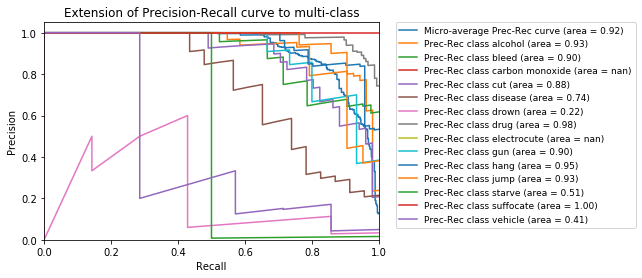

In [25]:
# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall_micro, precision_micro,
         label='Micro-average Prec-Rec curve (area = {0:0.2f})'
               ''.format(average_precision_micro))
for i, name in zip(range(n_classes),list(lb.classes_)):
    plt.plot(recall[i], precision[i],
             label='Prec-Rec class {0} (area = {1:0.2f})'
                   ''.format(name, average_precision[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1), prop={'size':9}, loc=2, borderaxespad=0.)
#plt.savefig('C:/Users/AshwinAmbal/Desktop/New Folder/Mass.png',dpi=200, bbox_inches='tight')
plt.show()